In [1]:
import mmh3
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
plot_titles = {
    0: "per-source destination flow",
    1: "per-source destination port flow",
    2: "per-destination source flow",
    3: "per-destination source port flow",
    4: "per-service source flow",
    5: "per-source service flow",
    6: "Original destination flow"
}
addition_info = "_1_min_"
addition_dir = "1 min"

In [3]:
type({1})

set

In [4]:
class MIME:
    '''
     prob: the overall sampling rate of MIME
     bits: the number of total bits in MIME
    '''
    def __init__(self, prob, bits):
        self.prob = prob
        self.bits = bits
        self.memory = self.bits / 8 / 1024
        self.B = np.zeros(shape = (self.bits, ), dtype = np.int8)
        self.hash_seed = 12412
        self.sample_seed = 97561
        self.port_seed = 91231
        self.bitcube_dc = dict()
        self.bitcube_dpc = dict()
        self.bitcube_sc = dict()
        self.bitcube_spc = dict()
        self.sample_nums = 0
        self.count_one = 0
        self.post_sampling_rate = self.prob
        self.split_num = 1 / self.prob
        self.real_spread_set_dc = defaultdict(set)
        self.real_spread_set_dpc = defaultdict(set)
        self.real_spread_set_spc = defaultdict(set)
        self.real_spread_set_sc = defaultdict(set)
        self.real_spread_set_service = defaultdict(set)
        self.real_spread_set_sservice = defaultdict(set)
        self.real_spread_set_OD = defaultdict(set)
        
        self.real_spreads_dc = defaultdict(int)
        self.real_spreads_sc = defaultdict(int)
        self.real_spreads_dpc = defaultdict(int)
        self.real_spreads_spc = defaultdict(int)
        self.real_spread_service = defaultdict(int)
        self.real_spread_sservice = defaultdict(int)
        self.real_spread_OD = defaultdict(int)
        
        self.pred_spreads_dpc = defaultdict(int)
        self.pred_spreads_dc = defaultdict(int)
        self.pred_spreads_sc = defaultdict(int)
        self.pred_spreads_spc = defaultdict(int)
        self.pred_spreads_service = defaultdict(int)
        self.pred_spreads_sservice = defaultdict(int) 
        self.pred_spreads_OD = defaultdict(int)
        
        self.are_dc = 0
        self.are_dpc = 0
        self.are_spc = 0
        self.are_sc = 0
        self.are_service = 0
        self.are_sservice = 0
        self.are_OD = 0
        
        self.dc_count = 0
        self.dpc_count = 0
        self.spc_count = 0
        self.sc_count = 0
        self.service_count = 0
        self.sservice_count = 0
        self.OD_count = 0
        
        self.are_range_dc = dict()
        self.are_range_dpc = dict()
        self.are_range_spc = dict()
        self.are_range_sc = dict()
        self.are_range_service = dict()
        self.are_range_sservice = dict()
        self.are_range_OD = dict()
        
        self.are_count_dc = dict()
        self.are_count_dpc = dict()
        self.are_count_spc = dict()
        self.are_count_sc = dict()
        self.are_count_service = dict()
        self.are_count_sservice = dict()
        self.are_count_OD = dict()
        
        for i in range(7):
            self.are_count_dc[i] = 0
            self.are_count_dpc[i] = 0
            self.are_count_sc[i] = 0
            self.are_count_spc[i] = 0
            self.are_count_service[i] = 0
            self.are_count_sservice[i] = 0
            self.are_count_OD[i] = 0
            
            self.are_range_dc[i] = 0
            self.are_range_dpc[i] = 0
            self.are_range_sc[i] = 0
            self.are_range_spc[i] = 0
            self.are_range_service[i] = 0
            self.are_range_sservice[i] = 0
            self.are_range_OD[i] = 0
    
    def update_bitcube_dc(self, src, dst, sport, dport):
        if src not in self.bitcube_dc:
            self.bitcube_dc[src] = {dst : {sport + " " + dport}}
        else:
            if dst not in self.bitcube_dc[src]:
                self.bitcube_dc[src][dst] = {sport + " " + dport}
            else:
                if sport + " " + dport not in self.bitcube_dc[src][dst]:
                    self.bitcube_dc[src][dst].add(sport + " " + dport)
    
    def update_bitcube_dpc(self, src, dst, sport, dport):
        if src not in self.bitcube_dpc:
            self.bitcube_dpc[src] = {dport : {dst + " " + sport}}
        else:
            if dport not in self.bitcube_dpc[src]:
                self.bitcube_dpc[src][dport] = {dst + " " + sport}
            else:
                if dst + " " + sport not in self.bitcube_dpc[src][dport]:
                    self.bitcube_dpc[src][dport].add(dst + " " + sport)
    
    def update_bitcube_sc(self, src, dst, sport, dport):
        if dst not in self.bitcube_sc:
            self.bitcube_sc[dst] = {src : {sport + " " + dport}}
        else:
            if src not in self.bitcube_sc[dst]:
                self.bitcube_sc[dst][src] = {sport + " " + dport}
            else:
                if sport + " " + dport not in self.bitcube_sc[dst][src]:
                    self.bitcube_sc[dst][src].add(sport + " " + dport)
    
    def update_bitcube_spc(self, src, dst, sport, dport):
        if dst not in self.bitcube_spc:
            self.bitcube_spc[dst] = {sport : {src + " " + dport}}
        else:
            if sport not in self.bitcube_spc[dst]:
                self.bitcube_spc[dst][sport] = {src + " " + dport}
            else:
                if src + " " + dport not in self.bitcube_spc[dst][sport]:
                    self.bitcube_spc[dst][sport].add(src + " " + dport)
    
    def sample(self, src, dst, sport, dport):
        #sport = str(mmh3.hash(sport, seed = 1, signed = False))
        #dport = str(mmh3.hash(dport, seed = 1, signed = False))
        key = src + dst + sport + dport
        hash_idx = mmh3.hash(key, seed = self.hash_seed) % self.bits
        if self.B[hash_idx] == 0:
            #sample_idx = mmh3.hash(key, seed = self.sample_seed) % 0xffffffff
            self.B[hash_idx] = 1
            self.count_one += 1
            #if sample_idx <= self.post_sampling_rate * 0xffffffff:
            if hash_idx <= self.post_sampling_rate * self.bits:
                self.update_bitcube_dc(src, dst, sport, dport)
                self.update_bitcube_dpc(src, dst, sport, dport)
                self.update_bitcube_sc(src, dst, sport, dport)
                self.update_bitcube_spc(src, dst, sport, dport)
            self.post_sampling_rate = (self.prob * self.bits) / (self.bits - self.count_one)
    
    def estimate(self, key, task):
        length_dict, num_dict = defaultdict(int), defaultdict(int)
        sum_ = 0
        if task == 0: # DC estimation
            if key not in self.bitcube_dc:
                return 1
            temp_bitarray = self.bitcube_dc[key]
            for dst in temp_bitarray:
                length_dict[dst] = len(temp_bitarray[dst])
            for dst in length_dict:
                num_dict[length_dict[dst]] += 1
        elif task == 1: # DPC estimation
            if key not in self.bitcube_dpc:
                return 1
            temp_bitarray = self.bitcube_dpc[key]
            for dport in temp_bitarray:
                length_dict[dport] = len(temp_bitarray[dport])
            for dport in length_dict:
                num_dict[length_dict[dport]] += 1
        elif task == 2: # SC estimation
            if key not in self.bitcube_sc:
                return 1
            temp_bitarray = self.bitcube_sc[key]
            for src in temp_bitarray:
                length_dict[src] = len(temp_bitarray[src])
            for src in length_dict:
                num_dict[length_dict[src]] += 1
        elif task == 3: #SPC estimation
            if key not in self.bitcube_spc:
                return 1
            temp_bitarray = self.bitcube_spc[key]
            for sport in temp_bitarray:
                length_dict[sport] = len(temp_bitarray[sport])
            for sport in length_dict:
                num_dict[length_dict[sport]] += 1
                
        if task in [0,1,2,3,4,5]:
            estimate_val = 0.0
            for k,v in num_dict.items():
                if k < math.ceil(self.split_num):
                    estimate_val += v / (1 - (1 - self.prob) ** k)
                else:
                    estimate_val += v / (1 - (1 - self.prob) ** int(k / self.prob))
            return int(round(estimate_val))
        else:
            return int(round(sum_ / self.prob))
        
    def run(self, filename):
        f = open(filename, 'r')
        datas = f.readlines()
        f.close()
        for pkt in tqdm(datas):
            src, dst, sport, dport = pkt.strip().split(",")
            self.real_spread_set_dc[src].add(dst)
            self.real_spread_set_spc[dst].add(sport)
            self.real_spread_set_dpc[src].add(dport)
            self.real_spread_set_sc[dst].add(src)
            self.sample(src, dst, sport, dport)
        print("Process data has been finished.")
        for src in tqdm(self.real_spread_set_dc):
            self.real_spreads_dc[src] = len(self.real_spread_set_dc[src])
            self.pred_spreads_dc[src] = self.estimate(src, 0)
        print("The estimation of Per-source destination flow has been finished.")
        for src in tqdm(self.real_spread_set_dpc):
            self.real_spreads_dpc[src] = len(self.real_spread_set_dpc[src])
            self.pred_spreads_dpc[src] = self.estimate(src, 1)
        print("The estimation of Per-source destination port flow has been finished.")
        for dst in tqdm(self.real_spread_set_sc):
            self.real_spreads_sc[dst] = len(self.real_spread_set_sc[dst])
            self.pred_spreads_sc[dst] = self.estimate(dst, 2)
        print("The estimation of Per-destination source flow has been finished.")
        for dst in tqdm(self.real_spread_set_spc):
            self.real_spreads_spc[dst] = len(self.real_spread_set_spc[dst])
            self.pred_spreads_spc[dst] = self.estimate(dst, 3)
        print("The estimation of Per-destination source port flow has been finished.")
    
    def draw(self, task):
        x_log, y_log = [], []
        if task == 0:
            for src in self.real_spreads_dc:
                temp_val = abs(self.real_spreads_dc[src] - self.pred_spreads_dc[src]) / self.real_spreads_dc[src]
                self.are_dc += temp_val
                self.dc_count += 1
                self.are_count_dc[int(np.log10(self.real_spreads_dc[src]))] += 1
                self.are_range_dc[int(np.log10(self.real_spreads_dc[src]))] += temp_val
                x_log.append(self.real_spreads_dc[src])
                y_log.append(self.pred_spreads_dc[src])
            self.are_dc = self.are_dc / self.dc_count
            for k in self.are_range_dc:
                self.are_range_dc[k] = self.are_range_dc[k] / self.are_count_dc[k] if self.are_count_dc[k] != 0 else 0
        elif task == 1:
            for src in self.real_spreads_dpc:
                temp_val = abs(self.real_spreads_dpc[src] - self.pred_spreads_dpc[src]) / self.real_spreads_dpc[src]
                self.are_dpc += temp_val
                self.dpc_count += 1
                self.are_count_dpc[int(np.log10(self.real_spreads_dpc[src]))] += 1
                self.are_range_dpc[int(np.log10(self.real_spreads_dpc[src]))] += temp_val
                x_log.append(self.real_spreads_dpc[src])
                y_log.append(self.pred_spreads_dpc[src])
            self.are_dpc = self.are_dpc / self.dpc_count
            for k in self.are_range_dpc:
                self.are_range_dpc[k] = self.are_range_dpc[k] / self.are_count_dpc[k] if self.are_count_dpc[k] != 0 else 0
        elif task == 2:
            for dst in self.real_spreads_sc:
                temp_val = abs(self.real_spreads_sc[dst] - self.pred_spreads_sc[dst]) / self.real_spreads_sc[dst]
                self.are_sc += temp_val
                self.sc_count += 1
                self.are_count_sc[int(np.log10(self.real_spreads_sc[dst]))] += 1
                self.are_range_sc[int(np.log10(self.real_spreads_sc[dst]))] += temp_val
                x_log.append(self.real_spreads_sc[dst])
                y_log.append(self.pred_spreads_sc[dst])
            self.are_sc = self.are_sc / self.sc_count
            for k in self.are_range_sc:
                self.are_range_sc[k] = self.are_range_sc[k] / self.are_count_sc[k] if self.are_count_sc[k] != 0 else 0
        elif task == 3:
            for dst in self.real_spreads_spc:
                temp_val = abs(self.real_spreads_spc[dst] - self.pred_spreads_spc[dst]) / self.real_spreads_spc[dst]
                self.are_spc += temp_val
                self.spc_count += 1
                self.are_count_spc[int(np.log10(self.real_spreads_spc[dst]))] += 1
                self.are_range_spc[int(np.log10(self.real_spreads_spc[dst]))] += temp_val
                x_log.append(self.real_spreads_spc[dst])
                y_log.append(self.pred_spreads_spc[dst])
            self.are_spc = self.are_spc / self.spc_count
            for k in self.are_range_spc:
                self.are_range_spc[k] = self.are_range_spc[k] / self.are_count_spc[k] if self.are_count_spc[k] != 0 else 0
        elif task == 4:
            for key in self.real_spread_service:
                temp_val = abs(self.real_spread_service[key] - self.pred_spreads_service[key]) / self.real_spread_service[key]
                self.are_service += temp_val
                self.service_count += 1
                self.are_count_service[int(np.log10(self.real_spread_service[key]))] += 1
                self.are_range_service[int(np.log10(self.real_spread_service[key]))] += temp_val
                x_log.append(self.real_spread_service[key])
                y_log.append(self.pred_spreads_service[key])
            self.are_service = self.are_service / self.service_count
            for k in self.are_range_service:
                self.are_range_service[k] = self.are_range_service[k] / self.are_count_service[k] if self.are_count_service[k] != 0 else 0
        elif task == 5:
            for key in self.real_spread_sservice:
                temp_val = abs(self.real_spread_sservice[key] - self.pred_spreads_sservice[key]) / self.real_spread_sservice[key]
                self.are_sservice += temp_val
                self.sservice_count += 1
                self.are_count_sservice[int(np.log10(self.real_spread_sservice[key]))] += 1
                self.are_range_sservice[int(np.log10(self.real_spread_sservice[key]))] += temp_val
                x_log.append(self.real_spread_sservice[key])
                y_log.append(self.pred_spreads_sservice[key])
            self.are_sservice = self.are_sservice / self.sservice_count
            for k in self.are_range_sservice:
                self.are_range_sservice[k] = self.are_range_sservice[k] / self.are_count_sservice[k] if self.are_count_sservice[k] != 0 else 0
        elif task == 6:
            for key in self.real_spread_OD:
                temp_val = abs(self.real_spread_OD[key] - self.pred_spreads_OD[key]) / self.real_spread_OD[key]
                self.are_OD += temp_val
                self.OD_count += 1
                self.are_count_OD[int(np.log10(self.real_spread_OD[key]))] += 1
                self.are_range_OD[int(np.log10(self.real_spread_OD[key]))] += temp_val
                x_log.append(self.real_spread_OD[key])
                y_log.append(self.pred_spreads_OD[key])
            self.are_OD = self.are_OD / self.OD_count
            for k in self.are_range_OD:
                self.are_range_OD[k] = self.are_range_OD[k] / self.are_count_OD[k] if self.are_count_OD[k] != 0 else 0
        x = y = np.arange(0, 7, 1)
        x_log = np.log10(x_log)
        y_log = np.log10(y_log)
        plt.plot(x_log, y_log, '*', color = 'black')
        plt.plot(x, y, color = 'black')
        plt.xlabel("Real Spreads",fontsize = 20)
        plt.ylabel("Estimated Spreads",fontsize = 20)
        plt.xticks(x, ["$10^{}$".format(i) for i in range(7)], rotation = 0, fontsize = 20)
        plt.yticks(y, ["$10^{}$".format(i) for i in range(7)], rotation = 0, fontsize = 20)
        #plt.title(plot_titles[task],fontsize = 20)
        plt.tight_layout()
        #plt.savefig("../experiments/Accuracy/SuperCube/Figures/" + addition_dir + "/" + "{}KB".format(int(self.memory)) + "/" + plot_titles[task] + addition_info + ".jpg")
        plt.show()
    
    def show(self):
        self.total_are_dict = {
            0 : self.are_dc, 1 : self.are_dpc, 2 : self.are_sc, 3 : self.are_spc, 4 : self.are_service, 5: self.are_sservice, 6 : self.are_OD
        }
        self.range_are_dict = {
            0:self.are_range_dc,1:self.are_range_dpc,2:self.are_range_sc,3:self.are_range_spc,4:self.are_range_service,5:self.are_range_sservice,6:self.are_range_OD
        }
        for i in range(7):
            filename = "../experiments/Accuracy/SuperCube/Tables/" + addition_dir + "/" + "{}KB".format(int(self.memory)) + "/" + plot_titles[i] + addition_info + ".txt"
            f = open(filename, 'w')
            f.write("Total ARE is {:.3f}.\n".format(self.total_are_dict[i]))
            for j in range(7):
                f.write("$[10^{},10^{})$:  {:.3f}.\n".format(j, j + 1, self.range_are_dict[i][j]))
            f.close()

In [5]:
import math
def getOptParams(N, p):
    return int(round(-1.0 * N / math.log(p)))

def get_opt_sampling_rates(N, b):
    return np.exp(-N / b)

The optimal sampling rate is 0.34612439990319016


  1%|          | 3011/336491 [00:00<00:41, 8016.25it/s]

Process data has been finished.


  3%|▎         | 10413/336491 [00:00<00:12, 26739.56it/s]

The estimation of Per-source destination flow has been finished.


  3%|▎         | 22127/744340 [00:00<00:08, 82152.14it/s]

The estimation of Per-source destination port flow has been finished.


  3%|▎         | 25493/744340 [00:00<00:06, 102867.37it/s]

The estimation of Per-destination source flow has been finished.


100%|██████████| 744340/744340 [00:02<00:00, 258600.72it/s]


The estimation of Per-destination source port flow has been finished.


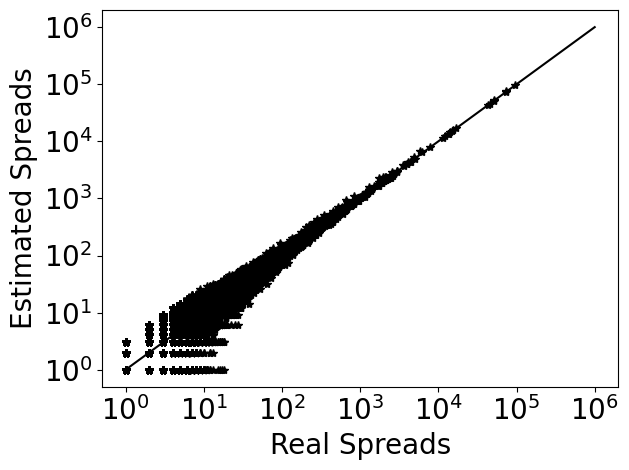

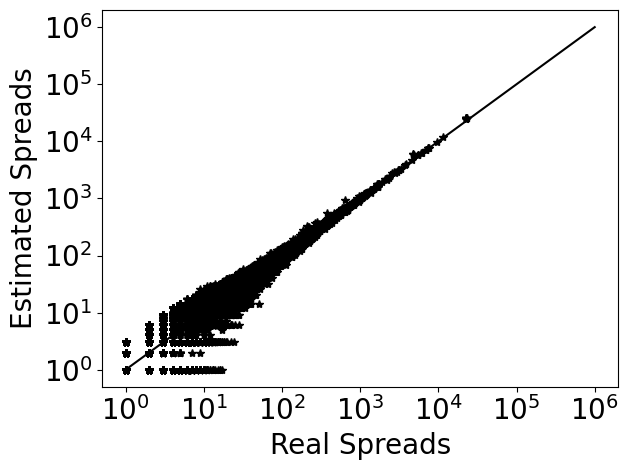

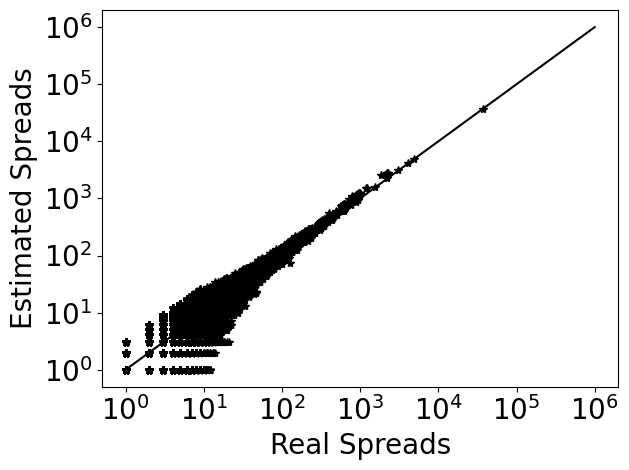

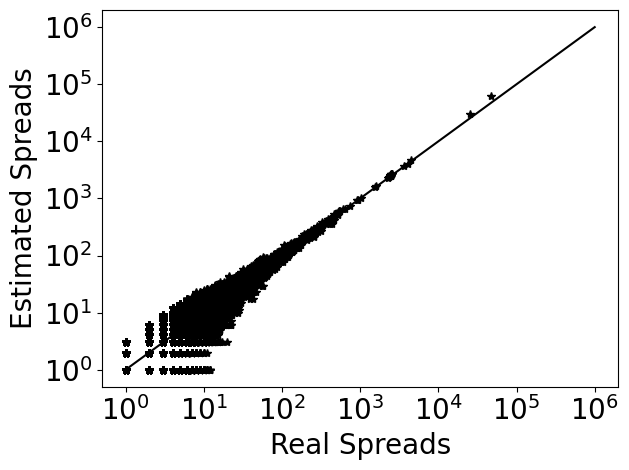

The optimal sampling rate is 0.5291019102248454


  0%|          | 276/336491 [00:00<02:01, 2759.46it/s]

Process data has been finished.


  1%|▏         | 4409/336491 [00:00<00:30, 10834.47it/s]

The estimation of Per-source destination flow has been finished.


  2%|▏         | 13355/744340 [00:00<00:17, 42147.86it/s]

The estimation of Per-source destination port flow has been finished.


  2%|▏         | 16965/744340 [00:00<00:13, 52410.42it/s]

The estimation of Per-destination source flow has been finished.


100%|██████████| 744340/744340 [00:03<00:00, 211737.16it/s]


The estimation of Per-destination source port flow has been finished.


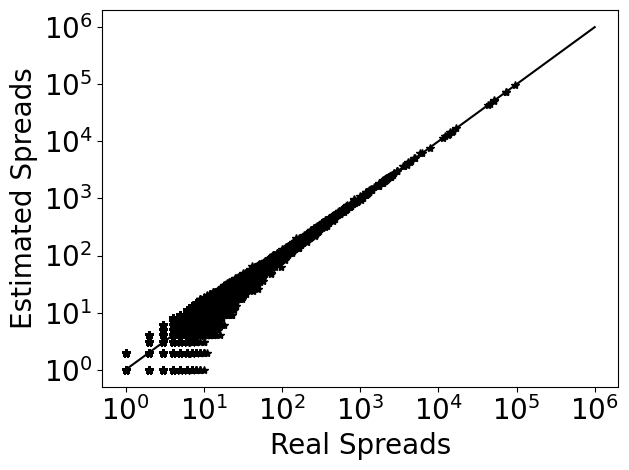

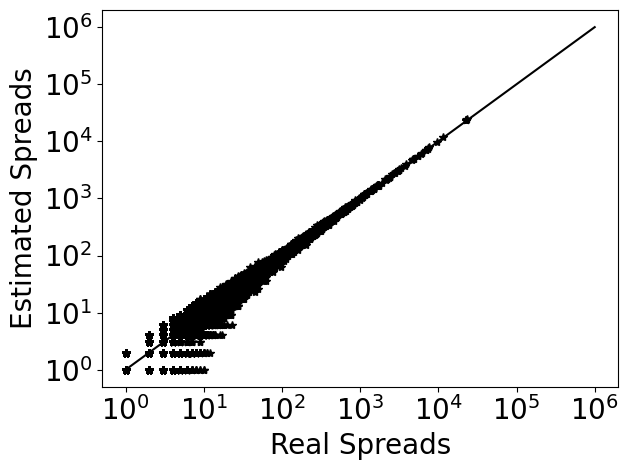

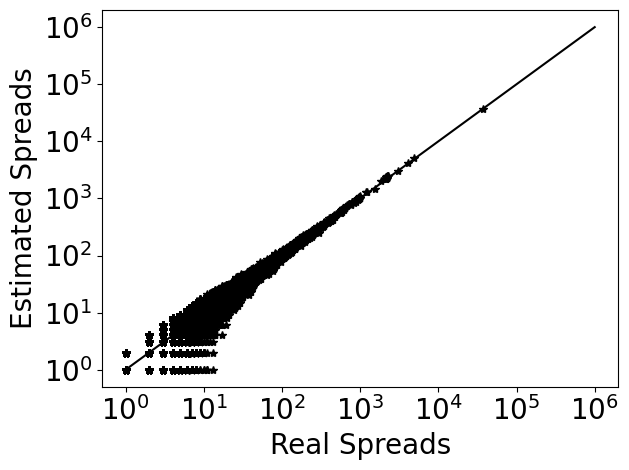

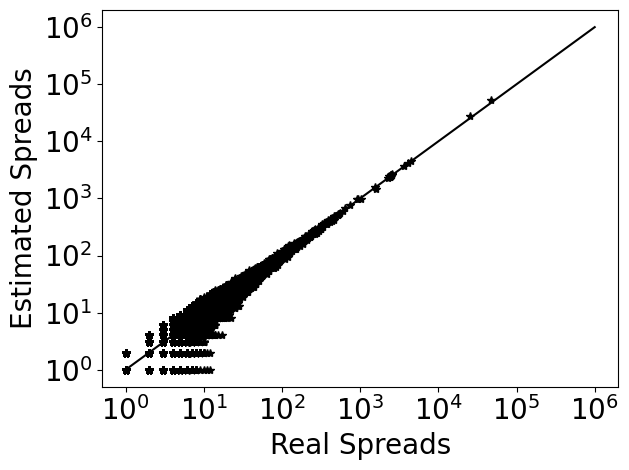

The optimal sampling rate is 0.6346409516133593


  0%|          | 128/336491 [00:00<04:25, 1267.13it/s]

Process data has been finished.


  1%|          | 3273/336491 [00:00<00:51, 6424.56it/s]

The estimation of Per-source destination flow has been finished.


  2%|▏         | 11539/744340 [00:00<00:21, 34344.97it/s]

The estimation of Per-source destination port flow has been finished.


  2%|▏         | 13931/744340 [00:00<00:19, 36703.35it/s]

The estimation of Per-destination source flow has been finished.


100%|██████████| 744340/744340 [00:03<00:00, 199239.66it/s]


The estimation of Per-destination source port flow has been finished.


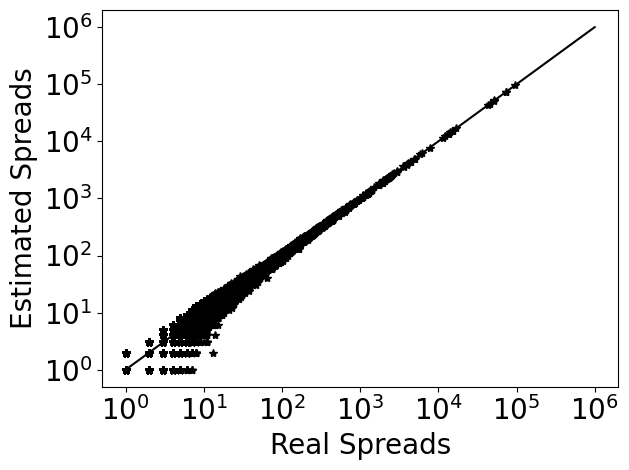

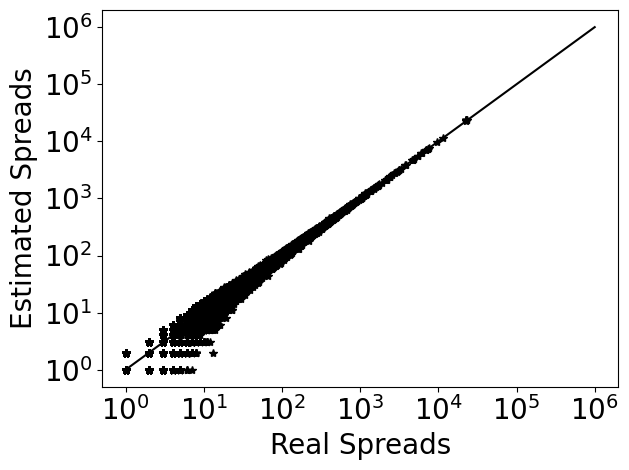

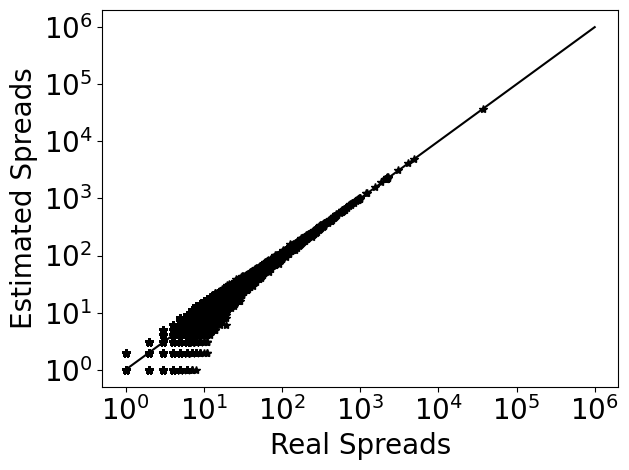

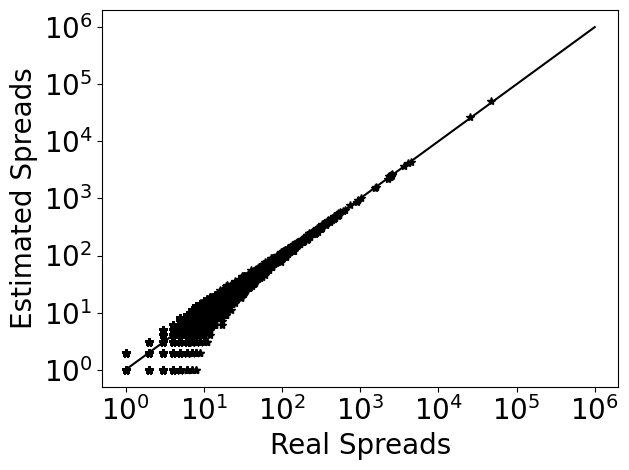

The optimal sampling rate is 0.7021190209954422


  0%|          | 1242/336491 [00:00<02:20, 2379.91it/s]

Process data has been finished.


  1%|          | 2520/336491 [00:00<00:58, 5711.37it/s]

The estimation of Per-source destination flow has been finished.


  1%|▏         | 10005/744340 [00:00<00:24, 29506.52it/s]

The estimation of Per-source destination port flow has been finished.


  2%|▏         | 12685/744340 [00:00<00:22, 32736.39it/s]

The estimation of Per-destination source flow has been finished.


100%|██████████| 744340/744340 [00:03<00:00, 189522.42it/s]


The estimation of Per-destination source port flow has been finished.


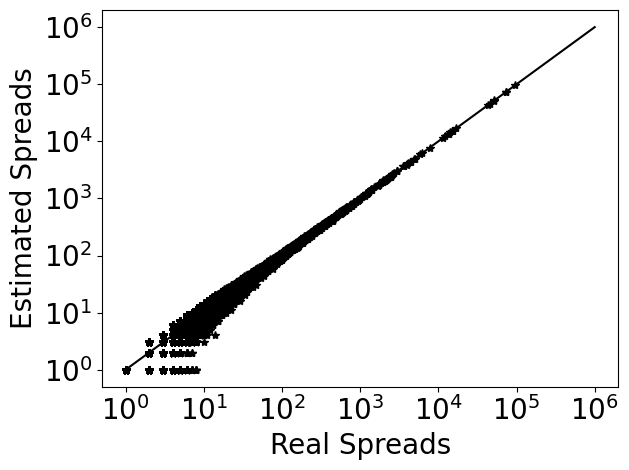

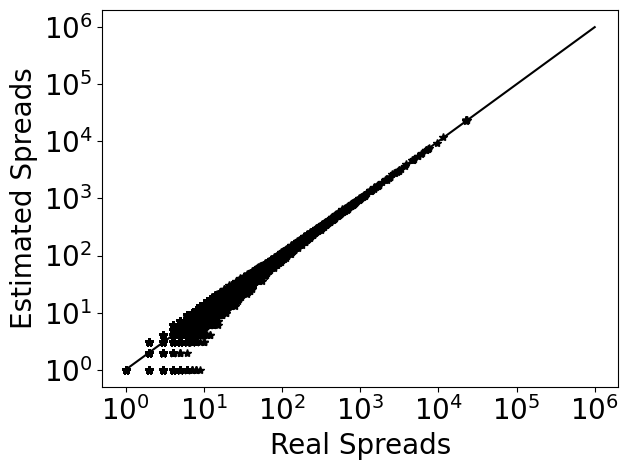

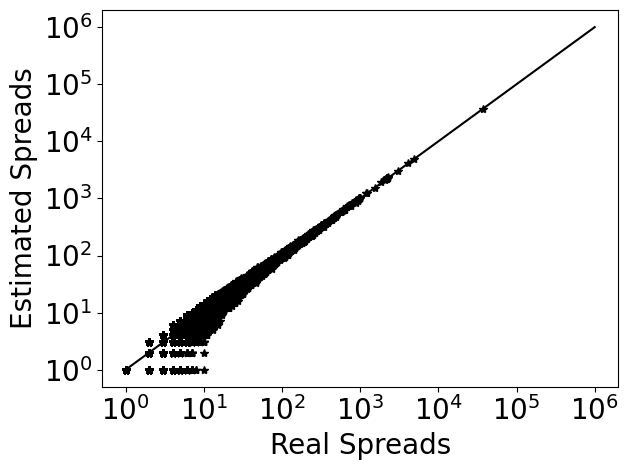

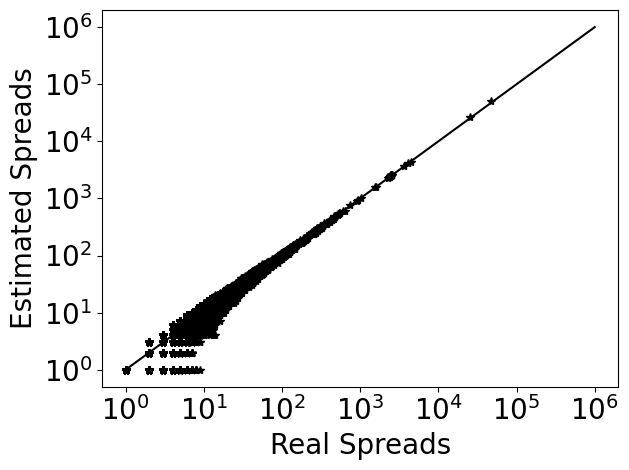

In [6]:
N = 2607408 #11405665
for m in [300, 500, 700, 900]:
    p = get_opt_sampling_rates(N, m * 8 * 1024)
    print("The optimal sampling rate is {}".format(p))
    mime = MIME(p, m * 8 * 1024)
    mime.run("../datas/supercube_dataset/00_processed.txt")
    mime.draw(0)
    mime.draw(1)
    mime.draw(2)
    mime.draw(3)
    #mime.show()